# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable
from IPython.display import clear_output
import math


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 64
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# transform = transforms.Compose([transforms.ToTensor()])



# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2),  # Reverse the normalization to get values in [0, 1]
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.Lambda(lambda x: x.permute(1, 2, 0))
])


# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def cosine_beta_schedule(T, s=0.008):
    steps = torch.linspace(0, T, T + 1, dtype=torch.float32)
    alpha_bar = torch.cos(((steps / T) + s) / (1 + s) * (math.pi / 2)) ** 2
    beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return beta.clamp(1e-5, 0.999)  # Avoid division by zero

T = 1000
beta = cosine_beta_schedule(T)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# Reshape for broadcasting (if required for your model)
alpha = alpha.view((T, 1, 1, 1)).to(device)
beta = beta.view((T, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


In [4]:
# # Linear noise schedule
# T = 1000
# beta_start, beta_end = 1e-4, 2e-2
# beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
# alpha = 1.0 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# # Reshape for broadcasting (if required for your model)
# alpha = alpha.view((T, 1, 1, 1)).to(device)
# beta = beta.view((T, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [10]:
import math
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32) * math.log(10000) / half_dim
        ).to(t.device)
        angles = t[:, None] * freqs[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [11]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.channels = [3,32, 64, 128, 256, 512]
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 16, 16)
                nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, padding=1),  # (batchsize, 64, 16, 16)
                nn.GroupNorm(4, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(self.channels[2], self.channels[3], kernel_size=3, padding=1),  # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 128, 4, 4)
                nn.Conv2d(self.channels[3], self.channels[4], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 256, 2, 2)
                nn.Conv2d(self.channels[4], self.channels[5], kernel_size=3, padding=1),  # (batchsize, 512, 2, 2)
                nn.GroupNorm(8, self.channels[5]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[5], self.channels[4], kernel_size=3,
                                      stride=2, padding=1, output_padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[4]*2, self.channels[3], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[3]*2, self.channels[2], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 16, 16)
                nn.GroupNorm(8, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[2]*2, self.channels[1], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.Conv2d(self.channels[1]*2, self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1),
                nn.Conv2d(self.channels[1], self.channels[0], kernel_size=1)  # (batchsize, 3, 32, 32)
            )      
        ])
        
        self.time_layers = nn.ModuleList([
                nn.Linear(128, self.channels[i]) for i in range(len(self.channels))
        ])


    def forward(self, x, t_emb):
        signal = x
        signals = []
        for i, conv in enumerate(self.convs):
            # print(f"signal shape: {signal.shape}")
            t_emb_processed = self.time_layers[i](t_emb).view(-1, self.channels[i], 1, 1)
            signal= t_emb_processed+signal
            signal = conv(signal)
            if i < len(self.convs)-1:
                signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            # print(f"signal shape: {signal.shape}")
            # print(f"signals[-{i}] shape: {signals[-i].shape}")
            # print()
            t_emb_processed = self.time_layers[-(i + 1)](t_emb).view(-1, self.channels[-(i + 1)], 1, 1)
            signal= signal+t_emb_processed
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)

        return signal



## Training loop

In [12]:
#from UNET import UNET
epochs = 200
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')

# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

In [ ]:
load_model = None
if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))

losses = []
batchlosses = []

# Training loop
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        t_norm = t.float() / T
        t_emb = time_embedding_layer(t_norm)  # Shape: [batch_size, embedding_dim]
        eps = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
        loss = criterion(predicted_eps, eps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        losses.append(loss.item())


        # if e % 100 == 99:
        #     print(f"Epoch {epoch}, Batch {e+1}, Average Loss: {np.mean(losses[-100:]):.4f}")
    
    batchlosses.append(np.mean(losses[-100:]))
    print(f"Epoch {epoch}, Average Loss: {batchlosses[-1]:.4f}")
    plt.plot(batchlosses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    clear_output(wait=True)

    if epoch % 2 == 0 and epoch > 0:
        torch.save(model.state_dict(), f"data_CIFAR/DDPM_{epoch}.pth")




# Sampling

In [ ]:
load_model = None

if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))
with torch.inference_mode():
    model.eval()
    batch_size = 1
    xt = torch.randn(batch_size, 3, 32, 32).to(device)

    for t in torch.arange(T-1, 0-1, -1):
        t = t.reshape(1)
        t = t.to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 0 else torch.zeros(batch_size, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t])/(torch.sqrt(1 - alpha_bar[t])) * 
                                                    model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new

image = torch.permute(xt,(2,3,1,0))
image = image.reshape(32,32,3)
print(image.max())
print(image.min())
#weird clipping
plt.imshow(image)

# Overfit one batch

In [13]:
#from UNET import UNET

model = UNET().to(device)
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

# Get a single image from the batch
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(1, 1, 1, 1)
# Set the model to training mode
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
plot_every = 400

running_loss = 0
# Training loop to overfit one batch
epochs = 5000
for epoch in range(epochs):
    t = torch.randint(0, T, (1,), device=device)
    t_norm = t.float() / T # Normalize the time to [0, 1]
    t_emb = time_embedding_layer(t_norm)  # Shape: [1, embedding_dim]
    eps = torch.randn_like(single_batchs).to(device)
    x_t = torch.sqrt(alpha_bar[t]) * single_batchs + torch.sqrt(1 - alpha_bar[t]) * eps
    predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
    loss = criterion(predicted_eps, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if epoch % 100 == 99:
        print(f"Epoch {epoch}, Average Loss: {running_loss / 100:.4f}")
        running_loss = 0.0  

    # if epoch % plot_every == 0:
    #     with torch.inference_mode():
    #         model.eval()
    #         t = torch.randint(0, T, (1,), device=device)
    #         t_emb = time_embedding_layer(t)
    #         eps = torch.randn_like(single_batch).to(device)
    #         x_t = torch.sqrt(alpha_bar[t]) * single_batch + torch.sqrt(1 - alpha_bar[t]) * eps
    #         predicted_eps = model(x_t, t_emb)
    #         reconstructed = x_t - predicted_eps
    #         fig, axs = plt.subplots(1, 3, tight_layout=True)
    #         axs[0].imshow(predicted_eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[0].set_title("Predicted Noise")
    #         axs[1].imshow(eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[1].set_title("True Noise")
    #         axs[2].imshow(np.abs(predicted_eps[0][0].cpu().detach().numpy()-eps[0][0].cpu().detach().numpy()), cmap="gray")
    #         axs[2].set_title("Difference in noise")
    #         plt.show()

Epoch 99, Average Loss: 2361.9143
Epoch 199, Average Loss: 965.3192
Epoch 299, Average Loss: 715.3903
Epoch 399, Average Loss: 570.3433
Epoch 499, Average Loss: 543.0333
Epoch 599, Average Loss: 376.7072
Epoch 699, Average Loss: 435.8806
Epoch 799, Average Loss: 402.7203
Epoch 899, Average Loss: 299.6741
Epoch 999, Average Loss: 242.1120
Epoch 1099, Average Loss: 262.6620
Epoch 1199, Average Loss: 283.2586
Epoch 1299, Average Loss: 239.3669
Epoch 1399, Average Loss: 198.6864
Epoch 1499, Average Loss: 256.3014
Epoch 1599, Average Loss: 303.7292
Epoch 1699, Average Loss: 245.0025
Epoch 1799, Average Loss: 182.1797
Epoch 1899, Average Loss: 174.6387
Epoch 1999, Average Loss: 158.4817
Epoch 2099, Average Loss: 226.3253
Epoch 2199, Average Loss: 188.6242
Epoch 2299, Average Loss: 142.9442
Epoch 2399, Average Loss: 223.9206
Epoch 2499, Average Loss: 170.1531
Epoch 2599, Average Loss: 236.6585
Epoch 2699, Average Loss: 128.4061
Epoch 2799, Average Loss: 198.6085
Epoch 2899, Average Loss: 205.

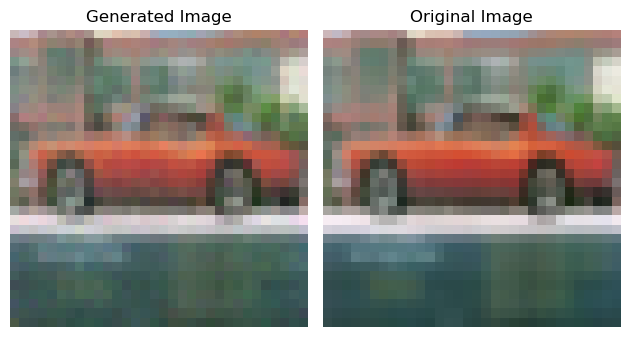

In [16]:
# Set the model to evaluation mode
model.eval()

# Initialize a random noise tensor
xt = torch.randn(1, 3, 32, 32).to(device)



# Perform the reverse diffusion process
with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_norm = t.float() / T
        
        t_emb = time_embedding_layer(t_norm)

        z = torch.randn(1, 3, 32, 32).to(device) if t > 0 else torch.zeros(1, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt_new = xt_new.clamp(-1, 1)
        xt = xt_new
        

# im1 = xt[0]
# im2 = single_batch[0]
# im1 = (im1+1)/2
# im1 = im1.permute(1, 2, 0)
# im1 = im1.cpu().detach().numpy()


# im2 = (im2+1)/2
# im2 = im2.permute(1, 2, 0)
# im2 = im2.cpu().detach().numpy()


# print(im1.min(),im1.max())

# fig,axs = plt.subplots(1, 2, tight_layout=True)
# axs[0].imshow(im1)
# axs[0].set_title("Generated Image")
# axs[0].axis("off")
# axs[1].imshow(im2)
# axs[1].set_title("Original Image")
# axs[1].axis("off")
# plt.show()


# Plot the generated image
fig,axs = plt.subplots(1, 2, tight_layout=True)
axs[0].imshow(reverse_transform(xt[0].cpu().detach()))
axs[0].set_title("Generated Image")
axs[0].axis("off")
axs[1].imshow(reverse_transform(single_batch[0].cpu().detach()))
axs[1].set_title("Original Image")
axs[1].axis("off")
plt.show()